### Reminder of the aim

We want to put an upper bound on the sensitivity of the function,

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j)$$

Where $a_i$ is the $i$th element of the $\mathbf{a} = K^{-1}y$ vector.

And $k(.,.)$ is the kernel function.

We obviously want to find a bound for $a_i$ and for the sum over $k(.,.)$s.

We first consider $K^{-1}y$;

### Warning about temr

### Bound on elements of $K^{-1}y$

It is useful to consider the eigenvalues and vectors of $K^{-1}$ to determine the bounds on the product $K^{-1}y$. It is useful also to consider that we can write $K^{-1} = U \Lambda^{-1} U^\top$. Where $U$ contains the eigenvectors of $K$ and $\Lambda$ contains a diagonal matrix of eigenvalues.

If we consider the case of two positively correlated variables (zero mean). We can see that the two eigenvectors of the covariance matrix will lie in the [1,1] and [-1,1] direction. The more correlated the two variables, the smaller the smallest eigenvalue will be. As they approach equality, then the smaller eigenvalue approaches zero. In the Gaussian Process world this occurs when two inputs get closer to each other.

<img src="correlation_example1.png">


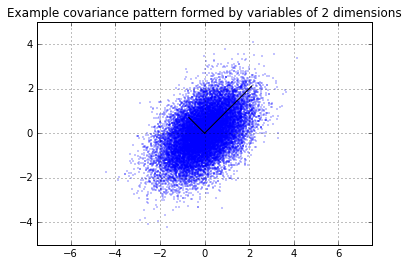

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_shape(corr):
    X = np.random.multivariate_normal(np.zeros(corr.shape[0]),corr,20000)
    plt.plot(X[:,0],X[:,1],'.',markersize=1)
    plt.axis('equal')
    plt.grid('on')
    plt.axes()
    plt.title('Example covariance pattern formed by variables of %d dimensions' % corr.shape[0])
    eig_val, eig_vec = np.linalg.eig(corr)
    for i in range(len(eig_val)):
        ev = eig_vec[:,i]*eig_val[i]*2
        plt.plot([0,ev[0]],[0,ev[1]],'k-')
plot_shape(np.array([[1,0.5],[0.5,1]]))

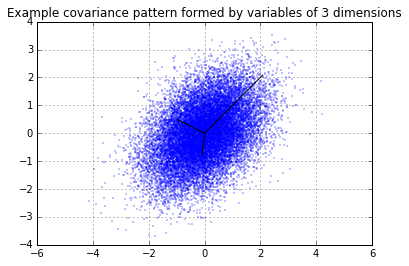

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plot_shape(np.array([[1,0.4,0.4],[0.4,1,0.4],[0.4,0.4,1]]))

#In this figure the scaled eigenvectors are projected onto the 2d x,y plane.

One can imagine how this extends to further dimensions, with each dimension (with correlation) added making the smallest eigenvalue even smaller. 

However, the eigenvectors will no longer face in the [1,-1,...] directions. In the figure above, one can see that the two smaller eigenvectors are not in any of the [1,-1...1] directions.

We've assumed that $\mathbf{y}$ is bounded within the $-1$ to $+1$ hypercube. In the simple 2d case, the largest element in $K^{-1}y$ is also bound within this cube as the eigen vectors face the hypercube's corners. Specifically it is reached when $y$ faces along the eigenvector associated with the largest eigen value. See left image.

For higher dimensions, the eigenvectors don't (generally) point in these directions (e.g. [-1,+1,+1,+1]). So the largest value of $K^{−1}y$ will involve the combination of several eigenvalues/vectors. Importantly the limit is no longer bound within that $-1$ to $+1$ hypercube.

This figure tries to illustrate this. Note that the output of the largest eigenvalue has been normalised to one, to allow easy comparison.

<img src="correlation_example2.png">

In the above figure, it is the reprojection into the space of the eigenvectors, combined with the sum of the eigenvector contributions, means that some elements of the output vector can be larger than one.

In [4]:
#We roughly mirror the above calculation

def dotransform(corr):
    G = np.linalg.inv(corr)
    U,L,V = np.linalg.svd(G)
    #normalise to reflect figure
    L = L/np.max(L)
    old_v = np.array([[1,-1]]).T
    print "original:    (%0.2f,%0.2f)" % (old_v[0],old_v[1])
    v = old_v
    #step by step (originally used to illustrate the steps of the SVD)
    v = np.dot(V,v)
    v = np.dot(np.diag(L),v)
    print "UVv:         (%0.2f,%0.2f)" % (v[0],v[1])
    v = np.dot(U,v)

    print "transformed: (%0.2f,%0.2f)" % (v[0],v[1])
    
print "For the example on the left (equal variance, 'angle' at 45 degrees)"
dotransform(np.array([[1,0.5],[0.5,1]]))
print "For the example on the right (unequal variance)"
dotransform(np.array([[1,0.25],[0.25,0.3]]))

For the example on the left (equal variance, 'angle' at 45 degrees)
original:    (1.00,-1.00)
UVv:         (-1.41,0.00)
transformed: (1.00,-1.00)
For the example on the right (unequal variance)
original:    (1.00,-1.00)
UVv:         (-1.26,0.13)
transformed: (0.51,-1.16)


We can consider the amount a vector could be scaled, and it seems likely that **an upperbound will be $\sqrt{\sum \lambda_i^2}$.**

Note: Interestingly, in the limit of a large number of equally spaced points, it seems that the largest value in the $K^{−1}y$ vector **is** equal to the inverse of the smallest eigenvalue in $K^{-1}$. 

The following code demonstrates these bounds for an arbitrary number of dimensions. Points are places on a **square grid** (closest packing would be interesting, but packings at higher dimensions have not been proved or known).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def kern(a,b): 
    a1 = x.repeat(x.shape[1],axis=1)
    b1 = np.tile(x,x.shape[1])
    return np.exp(-np.sum((a1-b1)**2,axis=0)).reshape(x.shape[1],x.shape[1])

N = 6 #number of steps in each dimension
dims = 4 #number of dimensions
dist = 1.4 #distance between points
x = np.arange(0,N)*dist

Ntot = 1
for it in range(dims-1):
    Ntot = Ntot * N
    x = np.vstack([np.tile(x,N),(np.arange(0,N)*dist).repeat(Ntot)])
    
K = kern(x,x)
G = np.linalg.inv(K)

print "Number of steps: %d. Number of dimensions: %d. Distance between points %0.2f" % (N,dims,dist)
print "Maxmimum value in G (for later analysis) = %0.4f" % np.max(G)
print "Maximum value in Gy (for -1<y<1) = %0.4f" % (np.max(np.sum(np.abs(G),axis=0)))
eigenvalues, _ = np.linalg.eig(K)
print "1/smallest eigenvalue = %0.4f" % (1.0/np.min(eigenvalues))
print "euclidean distance = %0.4f" % np.sqrt(np.sum((1.0/eigenvalues)**2))

Number of steps: 6. Number of dimensions: 4. Distance between points 1.40
Maxmimum value in G (for later analysis) = 1.1796
Maximum value in Gy (for -1<y<1) = 3.6921
1/smallest eigenvalue = 3.2165
euclidean distance = 44.2228


Some example results:

| Number of dimensions | Number of points in each dimension | Minumum distance between points | Actual maximum value in $K^{-1}y$ | Inverse of smallest eigenvalue  ($1/\lambda$) | Length of combined eigenvalues $\sqrt{\sum \lambda_i^2}$ | Notes |
|----------------------|------------------------------------|---------------------------------|-----------------------------------|-----------------------------------------------|----------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| 3 | 5 | 1 | 25.9 | 17.7 | 38.0 | When only a few points are close together, the approximate value ($1/\lambda$) does not work. |
| 3 | 9 | 1 | 35.2 | 27.7 | 108.4 | With enough points, it starts to approach the correct value. The correct bound becomes very poor (too big). |
| 3 | 15 | 1 | 36.72 | 32.87 | 253.02 | In the limit the $1/\lambda_{min}$ bound (for an infinite number of points) starts to be ideal, for any number of points. |
| 2 | 50 | 1 | 11.1 | 11.0 | 140.4 | Another example of the above bound working, using 2d data. |
| 2 | 3 | 1 | 5.5 | 4.2 | 5.7 | |
| 3 | 10 | 10 | 1.00 | 1.00 | 11.18 | Putting the points far apart. Again, the 'correct' bound is much larger than the real value. |
| 3 | 5 | 2 | 1.118 | 1.101 | 11.207 | Just enough distance makes our approximation reasonable. |
| 6 | 3 | 2 | 1.246 | 1.17 | 27.11 | Even with lots of dimensions the approximation isn't far off. |
| 6 | 3 | 1.6 | 2.55 | 2.00 | 29.02 | The result is sensitive to this distance, and is weaker at higher dimensions. |

$y$ is assumed to be between -1 and 1 in the above.

It is worth noting that the tightest bound seems to be $1/\lambda_{min}$ for an infinite number of points. The more easily computed $\sqrt{\sum \lambda_i^2}$ is however a valid upper bound, but is unreasonably large for many cases.

### Pragmatic Hack

**For my purposes I'll state that:**

**the largest value of an element in $\mathbf{a} = K^{-1}\mathbf{y}$ is bounded by $|a_i| \leq 2 \times y_{max}$. We just need to select the distance between points such that this bound is preserved.**

For two dimensions this distance is 1.4 $\times$ length scale.

This seems a long way apart, but hopefully, by using inducing points, this constraint won't be too serious. If it is we can switch to using the above calculated bounds. We would need to be careful in that case as the noise statistics will hold information about the data.

**It is this bound that I'd like to clarify and prove**

### Possible other bound?

<small>Note: Ideally, if we put a bound on how correlated each pair of variables is (i.e. by proximity of points), how do we find a bound for the largest eigenvalue in the $K^{-1}$ matrix? We can use this as an alternative way of making a bound by noting that all the other eigenvalues are equal or less to this value, so the scaling effect of the transform will be bounded by $\sqrt{N_{inputs} \times \lambda_{max}^{2}}$. (where $\lambda_{max}$ is the largest eigenvalue in the inverse covariance matrix).</small>

### Size of the kernel value

The equation above depends on summing over a set of kernels (scaled by the above values). What bounds can we set on this sum?

$\sum_i \sum_j k(x_i, x_j)$

We have decreed that the points $\mathbf{x}$ are placed at least $d$ apart. So the sum of (stationary) kernels will be bounded.

$e^{-d^2} + e^{-(2d)^2} + e^{-(3d)^2} +\;... $

This looks like the integral of a gaussian.

We can put an upper bound on the sum.

If we note that the sum geometrically looks like the shaded area of this figure:

<img src="integrate.png">

We can note that the first block has a height of one, then the following are bounded by ${}^1/_2 \times Area$ (of a gaussian). We can extend this for arbitrary distances between inputs, leading to:

$$\sum_{i=0}^{\infty} e^{-(d i)^2} \leq 1 + {{\sqrt{\pi}} \over 2 d}$$


### Putting it together

To summarise,

We are using the approximation that there are no elements in $K^{-1}\mathbf{y} = \mathbf{a}$ above a certain bound, i.e. $|a_i| \leq 2 y_{max}$. The sum of the kernels is bounded by $1 + {{\sqrt{\pi}} \over 2d}$. Putting these together in:

$$\sum_i \sum_j a_i a_j k(x_i, x_j)$$

gives us an upper bound on the total of:

$$2\;N \Big(1 + {{\sqrt{\pi}} \over 2\;d} \Big) \Big(2\;y_{max}\Big)^2$$

Applying to the full expression, we just multiply the bound by four (to handle the four terms, which we assume are independent as a worst case scenario),

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j) \leq 8 N \Big(1 + {{\sqrt{\pi}} \over 2\;d} \Big) \Big(2\;y_{max}\Big)^2$$

so we can write that:

$$\Delta = 4 \;y_{max} \sqrt{2N \Big( 1 + {\sqrt{\pi} \over {2 d}} \Big) }$$

This bound has the property that it is of $O(\sqrt{N})$ rather than $O(N)$, the previous bound had (that just assumed all kernels equalled one).

For the example with $N=400$, $y_{max}=10$; the resulting sensitivity was 16,000. For this, with $d=2$ the sensitivity is now about 1359, an 11 fold improvement.

The sensitivity is still far too large.

#### Sensitivity

Does this make sense? The height of the mean function we don't really expect to be proportional to N in any way, so it does seem odd that the noise we need to add is proportional to a function of N, and not ideal...

### Protecting just the outputs

If we go through the same reasoning, can we work out the sensitivity of the function for y?

I originally hoped that this would provide a lower sensitivity, however it seems to have a sensitivity of the same complexity as when we add privacy to the inputs. This is because, although the kernel component of the (representer theorem) summation is equal for both the 'prime and original databases, the factor it is multiplied by differs for each value of $i$.

The first thing to note is that the kernel function, $k(.,.)$, will remain the same regardless of the value of the $y_i'$.

Second we need to consider how the values in $\mathbf{a} = K^{-1}\mathbf{y}$ will differ from those in $\mathbf{a'} = K^{-1}\mathbf{y'}$.

Let $G = K^{-1}$,

$\mathbf{a} - \mathbf{a'} = G \mathbf{y} - G \mathbf{y'}$

The ith row of $\mathbf{a}$:
$a_i = G_{i1} y_1 + ... + G_{in} y_n$

$a_i' = G_{i1} y_1 + ... + G_{in} y_n'$

So $a_i - a_i' = G_{in} (y_n - y_n')$

$$f_D - f_D' = \sum_{i=1}^N G_{in}\;(y_n - y_n')\;k(x,x_i)$$

The largest difference between these values is going to be when the $(y_n - y_n')$ term is largest, which is bound by $y_{max}$. 

The largest value in $G$ can be bound above by 2 (if we place the kernels sufficiently far apart).

So we can put a bound on the difference between these functions;

$$f_D - f_D' \leq \sum_{i=1}^N 2\; y_{max} \; k(x,x_i)$$

$$f_D - f_D' \leq 2\; y_{max} \sum_{i=1}^N \; k(x,x_i)$$

So the norm of the difference between the functions is;

$$|| f_D - f_D'||^2 \leq 2^2\; y_{max}^2 \left< \sum_{i=1}^N \; k(x,x_i), \sum_{i=1}^N \; k(x,x_i) \right>$$

Applying the kernel trick we have:

$$|| f_D - f_D'||^2 \leq 2^2\; y_{max}^2 \sum_{i=1}^N \sum_{j=1}^N k(x_i,x_j)$$

We previously have found a bound for the summation of exponents,

$\sum_{i=1}^N \sum_{j=1}^N k(x_i,x_j) \leq N \left( 1 + {{\sqrt{\pi}} \over {2 \delta}} \right)$

Substituting into the above inequality;

$$|| f_D - f_D'|| \leq 2\; y_{max} \sqrt{N \left(1 + {\sqrt{\pi} \over {2 \delta}} \right)}$$

Sadly this is still $O(\sqrt{N})$, meaning that oddly with more points we need more noise, even though what we are trying to hide is the value of one y-value.

## Inducing inputs to the rescue

We can reduce the sensitivity of the function by considering the effect of a change of a location of an input, on the inducing points. 

If we use a set of inducing points (as inputs and outputs, with error associated with each output), then the location of the inducing points will be less sensitive to the location of the inputs, and so we would have a smaller effect on both $y_{max}$ and on the locations of the inducing inputs. The constraint on the amount the inputs can move, doesn't help with the estimate of the sensitivity.
    
What do we want to know?

- What is the largest distance an inducing input would move due to a point moving, "usually".
- How usual is this?

This seperation into events which are 'usual' and 'unusual' will in future allow us to use the $\delta$ part of the $(\varepsilon, \delta)$ to state that the output is differentially private with probability $1-\delta$.

We really need to know how far the function can move in $y$ at the location of the inducing input, due to the movement of the last element.

I'll first however look at how much the inducing inputs move (i.e. in x).

Let's first try out a few examples;

First with a nice spread of points;

Populating the interactive namespace from numpy and matplotlib


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f5f0ae00f90>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f5f0b245150>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f5f0b245c90>]}

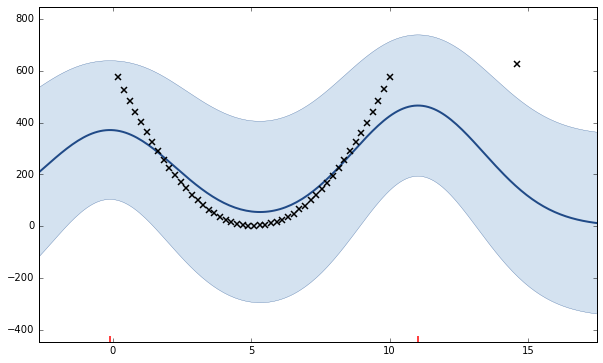

In [27]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
M = 2
noise_var = 1
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+(np.arange(-N/2,N/2,1.)[:,None])**2
Z = np.linspace(0,10,M)[:,None]

newposes = np.arange(-5,15,0.4)
ind_positions = np.zeros((M,len(newposes)))
for i,newpos in enumerate(newposes):
    X[0] = newpos
    m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,i] = np.sort(m.inducing_inputs.values.squeeze())
m.plot()



(-5, 15)

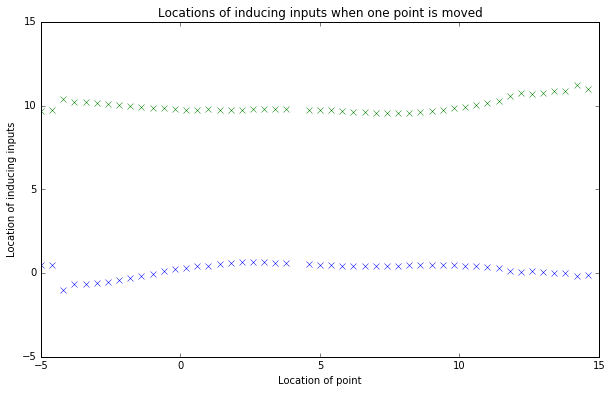

In [28]:
plt.plot(newposes,ind_positions.transpose(),'x')
plt.title('Locations of inducing inputs when one point is moved')
plt.xlabel('Location of point')
plt.ylabel('Location of inducing inputs')
plt.ylim([-5,15])

In [29]:
temp = ind_positions[:,np.sum(abs(ind_positions)>50,0)==0]
np.std(temp,1)
#np.std(ind_positions,1)

array([ 0.40185856,  0.43026689])

The inducing inputs don't move much, across the range of inputs, with a standard deviation of about 0.40-0.45. Note that occasionally there are locations where the values are very different. This is because we've got too many inducing inputs to explain such a simple shape.

If the data is clumped or shaped differently, with gaps ready for outliers or ways of shaping the data, then the effect of the single point is much greater on the inducing inputs.

In this case I've also increased the number of inducing inputs to illustrate how the data point can be 'followed' by the inducing inputs if it's an outlier.

Populating the interactive namespace from numpy and matplotlib


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f5f0ab36590>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f5f0aacbc10>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f5f0aacbbd0>]}

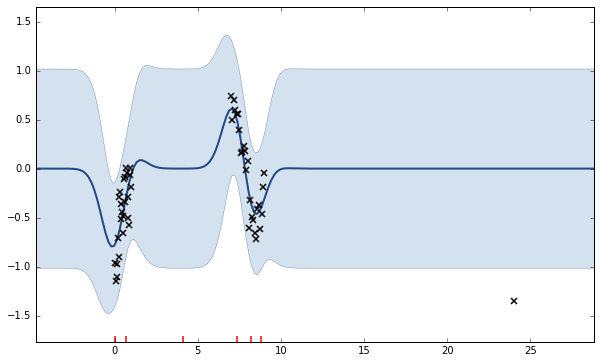

In [37]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50

noise_var = 0.001
X = np.linspace(0,2,N)[:,None]
X[N/2:N] = np.linspace(7,9,N/2)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-N/2,N/2,1.)[:,None]*0.01

M = 6
Z = np.linspace(0,10,M)[:,None]
newposes = np.arange(-5,25,1.0)
ind_positions = np.zeros((M,len(newposes)))
for i,newpos in enumerate(newposes):
    X[0] = newpos
    m = GPy.models.SparseGPRegression(X,y,Z=Z)
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,i] = np.sort(m.inducing_inputs.values.squeeze())
    
m.plot()


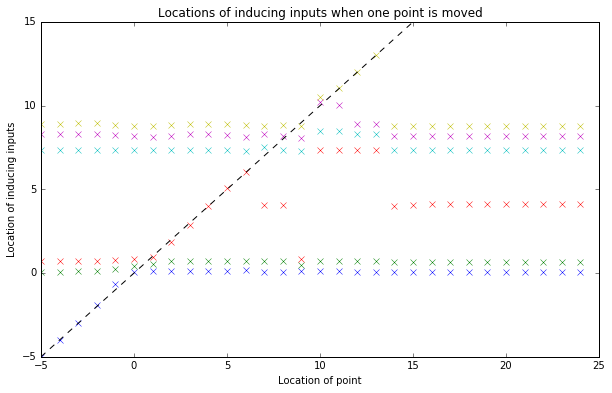

In [39]:
plt.plot(newposes,ind_positions.transpose(),'x')
plt.title('Locations of inducing inputs when one point is moved')
plt.xlabel('Location of point')
plt.ylabel('Location of inducing inputs')
plt.xlim([-5,25])
plt.plot([-5,15],[-5,15],'k--')

## Summary

Some data sets will be more susceptible to the movement of a data point than others. How likely are those datasets? And how likely is it that the point will land on a location which involves a large movement of the inducing inputs?

Both questions feel fairly domain specific.

Importantly if the data point becomes an outlier the inducing inputs will lie on top of it, which might show up later in the output. I've illustrated this in the second example by having enough spare inducing inputs to 'follow' this outlier.

Questions:

- Can we select the number of inducing inputs to 'always' ignore outliers?
- I think it doesn't matter if an inducing input does 'follow' the data point, as long as it's not for too long (we're wanting to put an upper bound on how much the inducing inputs change for an input).


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f5f0a63c150>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f5f0a6a37d0>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f5f0a6a3790>]}

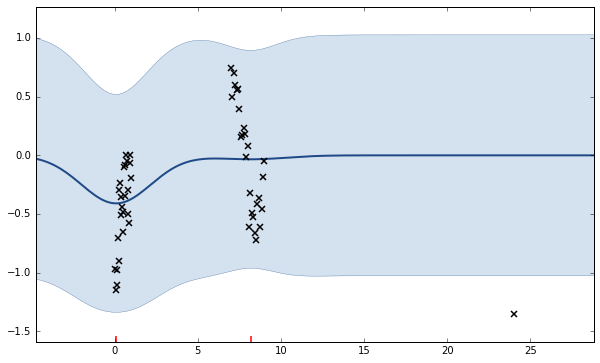

In [42]:
M = 2
Z = np.linspace(0,10,M)[:,None]
newposes = np.arange(-15,25,1.0)
ind_positions = np.zeros((M,len(newposes)))
for i,newpos in enumerate(newposes):
    X[0] = newpos
    m = GPy.models.SparseGPRegression(X,y,Z=Z)
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,i] = np.sort(m.inducing_inputs.values.squeeze())
m.plot()

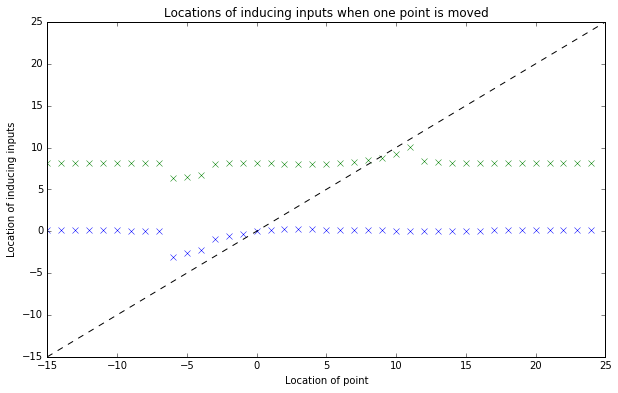

In [44]:
plt.plot(newposes,ind_positions.transpose(),'x')
plt.title('Locations of inducing inputs when one point is moved')
plt.xlabel('Location of point')
plt.ylabel('Location of inducing inputs')
plt.xlim([-15,25])
plt.plot([-15,25],[-15,25],'k--')

With just two inducing inputs, although the change in the input is over a domain of 40. The inducing inputs don't change by more than...

In [54]:
np.max(ind_positions,1)-np.min(ind_positions,1)

array([ 3.36752411,  3.65172353])

...3.4. In x we seem to have much less sensitivity, now we're using inducing inputs.

Solution:

** For a given data and number of inducing points set we determine this value, and use that **

Notes:

- We might be releasing information about data within the dataset by using it to select the range. There are ways to do this!

- Remember that what we actually get to release is not an analytical function expression, as we're having to add a noise sample (and we can't give someone ("RealData")+("Noise"), but instead we have to give them ("RealData+Noise").

In [5]:
import numpy as np
import pandas as pd
ratings = pd.read_table('ml-1m/ratings.dat',sep='::',names=['user','movie','rating','time'])
users = pd.read_table('ml-1m/users.dat',sep='::',names=['user','gender','age','occupation','zip'])
movies = pd.read_table('ml-1m/movies.dat',sep='::',names=['movie','title','genre'])

/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


In [6]:
movielens = pd.merge(pd.merge(ratings,users),movies)

In [7]:
lists = []

#get the most popular movies...
count = movielens.groupby('movie').size()
count.sort_values(inplace=True,ascending=False)
pop_movies = count.index[0:3]

for m in pop_movies:
    lists.append([])
    lists[-1]= movielens[movielens.movie==m].user.values
done = set(lists[0])
for l in lists: #unnecessary reapplies to list 0
  #  print len(done)
    done = done.intersection(set(l))
print "%d people have seen the top %d popular films" % (len(done), len(pop_movies))
done = list(done)

1469 people have seen the top 3 popular films


In [8]:
ml = movielens
ml = ml[ml['movie'].isin(pop_movies) & ml['user'].isin(done)].copy()

ml.sort_values(['user','movie'],inplace=True)
data = ml.rating.values
data = data.reshape([len(data)/3,3])
data = np.hstack([data,ml.age.values[0:len(done)][:,None]])

In [9]:
data

array([[ 5,  4,  4, 25],
       [ 5,  5,  3, 25],
       [ 4,  4,  4, 25],
       ..., 
       [ 4,  3,  4, 18],
       [ 5,  5,  5, 45],
       [ 4,  3,  4, 45]])

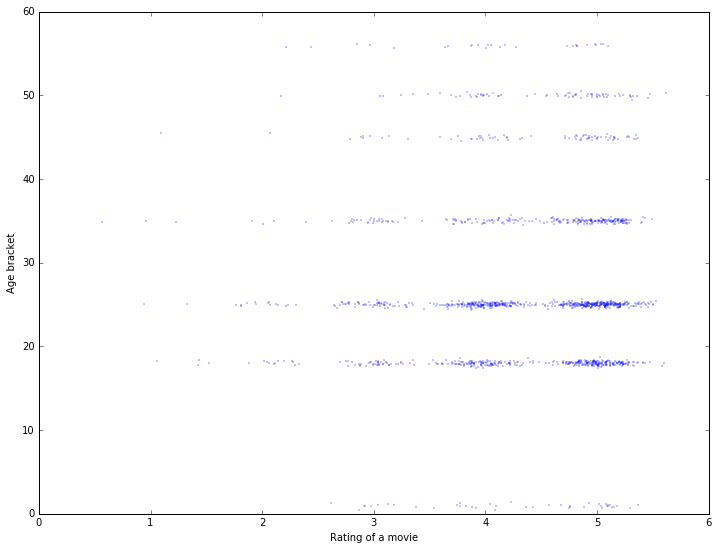

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data[:,1]+np.random.randn(1469)*0.2,data[:,3]+np.random.randn(1469)*0.2,'.',markersize=1)
plt.xlabel('Rating of a movie')
plt.ylabel('Age bracket')

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


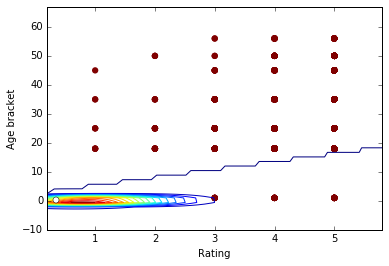

In [12]:
%pylab inline
import GPy
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
M = 2
noise_var = 1
X = data[:,[0,3]]
y = data[:,2][:,None] #we'll treat movie #2 as the output
Z = np.random.rand(2,2)
m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
m.likelihood.variance = noise_var
m.optimize()

m.plot()
plt.xlabel('Rating')
plt.ylabel('Age bracket')
#scale of noise to add...

#how much effect does moving one point have?

In [14]:
its = 40
ind_positions = np.zeros((4,its))
print ind_positions.shape
minX = np.min(X,0)
maxX = np.max(X,0)
for it in range(its):
    newX = np.random.rand(2)*(maxX-minX)+(minX)
    X[0,:]=newX
    Z = np.array([[2,3],[4,5]])
    m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,it] = np.sort(m.inducing_inputs.values.reshape(4,1).squeeze())

(4, 40)


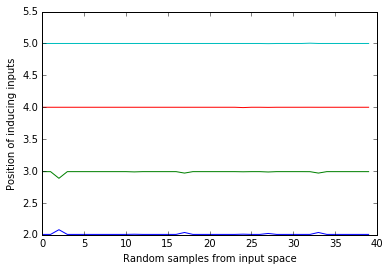

In [15]:
plt.plot(ind_positions.T)
plt.xlabel('Random samples from input space')
plt.ylabel('Position of inducing inputs')

In [16]:
np.max(np.max(ind_positions,1) - np.min(ind_positions,1))

0.10446878253035896

So in this example, even though we're moving the data between 1 and 5, the sensitivity of the inducing inputs is only 0.1.

To make the above example easier to draw, I repeat it in 2d.

Populating the interactive namespace from numpy and matplotlib


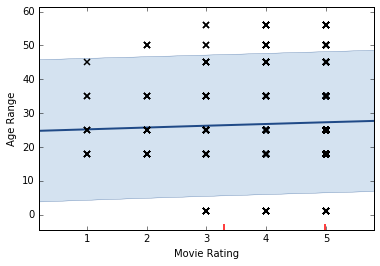

In [17]:
%pylab inline
import GPy
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
M = 2
noise_var = 1
X = data[:,[0]]
y = data[:,3][:,None] #we'll treat movie #2 as the output
Z = np.random.rand(2,1)
m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
m.likelihood.variance = noise_var
m.optimize()

m.plot()
plt.xlabel('Movie Rating')
plt.ylabel('Age Range')
#scale of noise to add...

#how much effect does moving one point have?

In [18]:
its = 10
ind_positions = np.zeros((2,its))
minX = np.min(X,0)
maxX = np.max(X,0)
for it in range(its):
    newX = int(np.random.rand(1)*(maxX-minX)+(minX))
    X[0,:]=newX
    Z = np.array([2,4])[:,None] 
    m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())
    m.likelihood.variance = noise_var
    m.optimize()
    ind_positions[:,it] = np.sort(m.inducing_inputs.values.reshape(2,1).squeeze())

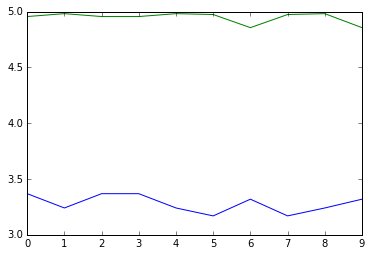

In [454]:
plt.plot(ind_positions.T)
plt.xlabel('Random sample from x')
plt.ylabel('Positions of inducing inputs')

In [458]:
np.max(np.max(ind_positions,1) - np.min(ind_positions,1))

0.19906643767737275

In [469]:
#average distance between inducing inputs (ie. delta)
mean(abs(ind_positions[0,:]-ind_positions[1,:]))

1.666834330281898

So the sensitivity in this case is 0.2. It seems to me that the sensitivity is large when there are too few inducing inputs (so they aren't well constrained and easily change with slight changes in the input).

What should the noise scale look like?

We need a value for $y_{max}$. We've learnt above what value of "$x_{max}$" is reasonable, so we need to convert from one to the other. This depends on the steepness of the function. If we use the actual function we're providing *another* way for information to leak from our noise generation (we'll be revealing something about the slope at each inducing input if we use that as the noise source). We'll roughly say that in this case the mean function's gradient is bound by $-1 \leq b \leq 1$

Plugging into our earlier equation:

$$\Delta = 4\;y_{max} \sqrt{N \Big( 1 + {\sqrt{\pi} \over {2 \delta}} \Big) }$$

We now have $y_{max} = 1.0 \times 0.2$ and $N = 2$ (where N is now the number of inducing inputs).

$$\Delta = 4 \times 1.0 \times 0.2 \times \sqrt{ 2 \times \Big( 1 + {\sqrt{\pi} \over {2 \times 1.67}} \Big) } = 1.4$$

### Is it valid that we use N as the number of inducing inputs?

I think so. My reasoning: We are at this point trying to protect the privacy of the inducing inputs, and we're completely forgetting that they represent real data. If we protect the privacy of the inducing inputs, then I can see no way that the real data that formed the inducing inputs could be inferred from the remains of the inducing inputs.

 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning:covariance is not positive-semidefinite.


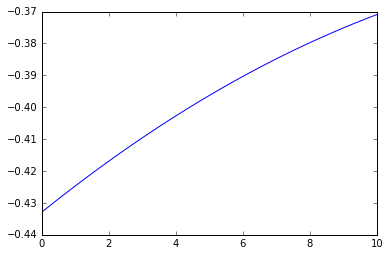

In [34]:
Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)/m.kern.variance).reshape(-1,1)
plt.plot(x,G)

(0, 50)

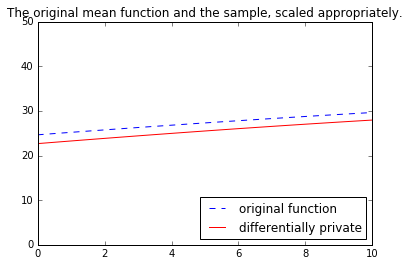

In [35]:
ypred = m.predict(x)[0]
plot(x,ypred,'--b',label='original function')
delta = 1.4
alpha = 1.0 #what's an acceptable level of epsilon? (and why am I using alpha not epsilon?)
beta = 0.01
c = np.sqrt(2*np.log(2/beta)) #c > sqrt(2 log (2/beta)) e.g. beta = 0.1, c = sqrt(2 log (2/0.1)) = sqrt(2 log (20)) = 2.45
scale = delta * c / alpha
plot(x,ypred+G*scale,'r-',label='differentially private')
plt.title('The original mean function and the sample, scaled appropriately.')
plt.legend(loc='lower right')
plt.ylim([0,50])

### Inducing inputs summary

Using inducing inputs makes our bound on $y_{max}$ smaller by the movement of one data point having a smaller effect on the position on the inducing inputs (so the largest movement they can experience [their sensitivity] is smaller], it spreads the data points apart so our bounds on the values in $K^{-1}$ are valid, and it means than $N$ is far smaller making our bounds smaller still.

# Questions

- Do I need to add white noise (i.e. the noise variance) to the output?
- Do I need to scale by y_max when scaling the kernel sample?
- Should I use N = actual inputs, or N = number of inducing inputs? Answered above: Inducing inputs
- How to handle other kernels? (non-stationary)?
- How to use data to estimate the sensitivity without revealing data?

In general: 

- **Is this valid?**